In [1]:
#Installing tensorflow version 2.2.0

!pip install tensorflow==2.2.0

In [68]:
# Importing the libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sklearn

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [69]:
# Loading the COVID-19 dataset

train_images = '/content/gdrive/MyDrive/Datasets/COVID-19 images/COVID dataset/train'
test_images = '/content/gdrive/MyDrive/Datasets/COVID-19 images/COVID dataset/test'

In [70]:
#Loading the VGG16 model.The inputs should be in the shape 224x224 as vgg16 is built on image dimension 224x224.

vgg_model = VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)

In [71]:
# Code on not to retrain the existing layers as the layers have already been trained

for layer in vgg_model.layers:
  layer.trainable = False

In [72]:
#Creating our own layers

top_model = vgg_model.output

#Flattening the base model/top model

top_model = Flatten()(top_model)

# Adding 3 dense layers at the end of the top model (base model)

prediction = Dense(3, activation='softmax')(top_model)

Learning rate schedule: 0.0001 to 0.0005 to 0.000264


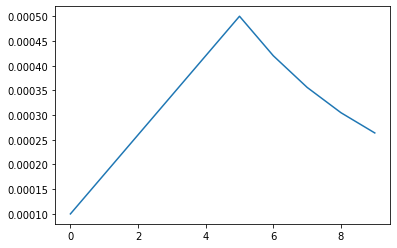

In [73]:
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

EPOCHS = 10

LR_START = 0.0001
LR_MAX = 0.0005
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(10 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [74]:
# Adding model checkpoints

# Creating Early stopping checkpoint

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True)

# Creating ReduceLROnPlateau checkpoint

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_delta=0.0001)

# Creating LearningRateScheduler checkpoint

schedule_lr = LearningRateScheduler(lrfn, verbose=1)

#Creating a list of callbacks defined

callbacks_list = [schedule_lr, early_stopping, reduce_lr]

In [75]:
#Creating an object of model

model = Model(inputs=vgg_model.input, outputs=prediction, name='VGGNet')

#Viewing the structure of the model

print(model.summary())

#Model - cost and optimization method to be used

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "VGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [76]:
batch_size = 32

#this is the augmentation configuration that we use for training

train_datagen = ImageDataGenerator(rescale=1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True)

# this is the augmentation configuration we use for testing
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of '/content/gdrive/MyDrive/Colab Notebooks/Datasets/Cats and dogs/Train_data', and indefinitely generate
# batches of augmented image data

train_generator = train_datagen.flow_from_directory(
                  '/content/gdrive/MyDrive/Datasets/COVID-19 images/COVID dataset/train', #this is the target directory
                  target_size=(224, 224), # all images will be resized to 224x224
                  batch_size=batch_size,
                  class_mode='categorical')# since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/Datasets/COVID-19 images/COVID dataset/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [77]:
#Fitting the model

history = model.fit(train_generator,
  validation_data=validation_generator,
  epochs=20,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator),
  callbacks=callbacks_list
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/20
8/8 [==============================] - 13s 2s/step - loss: 1.0684 - accuracy: 0.3865 - val_loss: 1.0110 - val_accuracy: 0.5303 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00018.
Epoch 2/20
8/8 [==============================] - 12s 1s/step - loss: 0.7249 - accuracy: 0.7849 - val_loss: 0.6841 - val_accuracy: 0.6818 - lr: 1.8000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00026000000000000003.
Epoch 3/20
8/8 [==============================] - 12s 2s/step - loss: 0.5094 - accuracy: 0.8247 - val_loss: 0.5134 - val_accuracy: 0.7727 - lr: 2.6000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00034.
Epoch 4/20
8/8 [==============================] - 12s 2s/step - loss: 0.3508 - accuracy: 0.8964 - val_loss: 0.4961 - val_accuracy: 0.7273 - lr: 3.4000e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00042.
Epoch 5/20


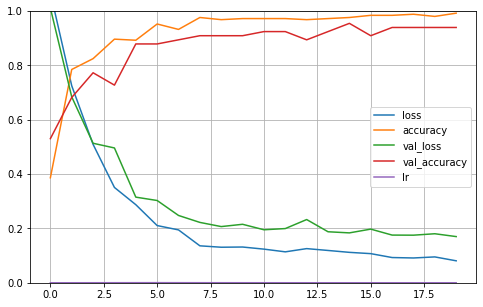

In [78]:
#Plotting the accuracy of the model

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [79]:
#Loading the image

img=image.load_img('/content/gdrive/MyDrive/Datasets/COVID-19 images/COVID dataset/test/Covid/0119.jpeg',target_size=(224,224))

# Converting the loaded image into an array
x=image.img_to_array(img)

# Expanding the image row-wise
x=np.expand_dims(x,axis=0)

# Pre processing the input image
img_data=preprocess_input(x)

In [80]:
# Predicting whether the X-Ray image is a COVID infected image or healthy image or Viral Pnuemonia image

a=np.argmax(model.predict(img_data), axis=1)

if(a==0):
  print("Covid")
elif(a==1):
  print("Normal")
else:
  print("Viral Pneumonia")

Covid


In [82]:
# Saving the model file

model.save('/content/gdrive/MyDrive/COVID19_VGG19.h5')